## Simple Time Series Prediction model with Prophet
### Scott Hendrickson


In [ ]:
import pandas as pd

from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

from matplotlib import pyplot as plt
%matplotlib inline

## Canonical Example for Prophet Website

In [ ]:
!ls ../data
df = pd.read_csv('../data/example_wp_log_peyton_manning.csv')
df.head()

### Many options, but a basic prophet model on daily data does the obvious seasonality detection

In [ ]:
m = Prophet()
m.fit(df)

### Even has a utility to create a data frame with historical and future predictions

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast, figsize=[15,10])

In [ ]:
fig2 = m.plot_components(forecast, figsize=[15,15])

## Get an idea of prediction quality using cross-validation

In [ ]:
df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '365 days')

In [ ]:
df_p = performance_metrics(df_cv)
print(len(df))
df_p.head(10)

# Deploy and Use Model

In [1]:
import requests
import json
import pandas as pd

In [2]:
#base_url = "http://localhost:5000"
base_url = "http://192.168.127.8/ts-model"
#base_url = "http://127.0.0.1"

In [3]:
res = requests.get(base_url + "/version")
print(res.json())

{'version': '0.2.1', 'date': '2022-06-13T22:12'}


In [4]:
res = requests.get(base_url + "/example")
print(res.json())

{'size': [2905, 2], 'data': [['2007-12-10', '9.59076113897809'], ['2007-12-11', '8.51959031601596'], ['2007-12-12', '8.18367658262066'], ['2007-12-13', '8.07246736935477'], ['2007-12-14', '7.8935720735049'], ['2007-12-15', '7.78364059622125'], ['2007-12-16', '8.41405243249672'], ['2007-12-17', '8.82922635473185'], ['2007-12-18', '8.38251828808963'], ['2007-12-19', '8.06965530688617'], ['2007-12-20', '7.87929148508227'], ['2007-12-21', '7.76174498465891'], ['2007-12-22', '7.52940645783701'], ['2007-12-23', '8.38526052015541'], ['2007-12-24', '8.62011072542292'], ['2007-12-25', '7.85243908535751'], ['2007-12-26', '7.85399308722424'], ['2007-12-27', '8.0519780789023'], ['2007-12-28', '7.92660259918138'], ['2007-12-29', '7.83834331555712'], ['2007-12-30', '9.70314458114435'], ['2007-12-31', '9.38597294061934'], ['2008-01-01', '8.29379960884682'], ['2008-01-02', '8.43468076984177'], ['2008-01-03', '8.26204284396694'], ['2008-01-04', '8.10681603894705'], ['2008-01-05', '7.95014988765202'], [

<AxesSubplot:xlabel='ds'>

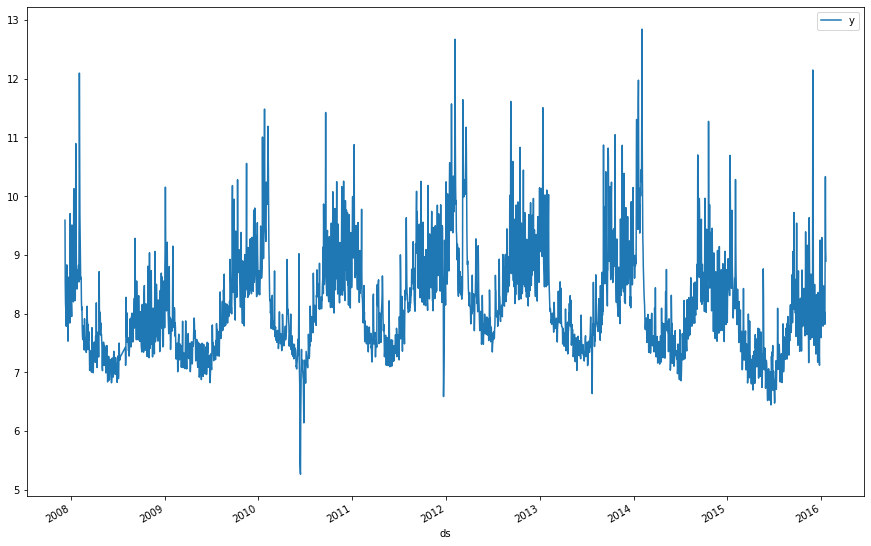

In [5]:
dft = pd.DataFrame(res.json()["data"], columns=res.json()["header"])
dft["ds"] = pd.to_datetime(dft['ds'])
dft["y"] = dft['y'].astype(float)
dft.plot("ds", "y", figsize=[15,10])

In [6]:
tr = requests.post(base_url + "/train", json = res.json())
print(tr)
print(tr.json())
model_id = tr.json()["model_id"]

<Response [200]>
{'size': [2905, 2], 'training_time': 13.546, 'model_id': '54e66fd46ea88d54e67a2172dba4757193232adf'}


In [7]:
print(model_id)
xv = requests.get(base_url + f"/validation/{model_id}", timeout=120)
print(xv)
print(xv.json())

54e66fd46ea88d54e67a2172dba4757193232adf


ReadTimeout: HTTPConnectionPool(host='192.168.127.8', port=80): Read timed out. (read timeout=120)

In [8]:
pr = requests.post(base_url + f"/predict", json = {"size": 180, "data":[], "model_id": model_id})

['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat']


<AxesSubplot:xlabel='ds'>

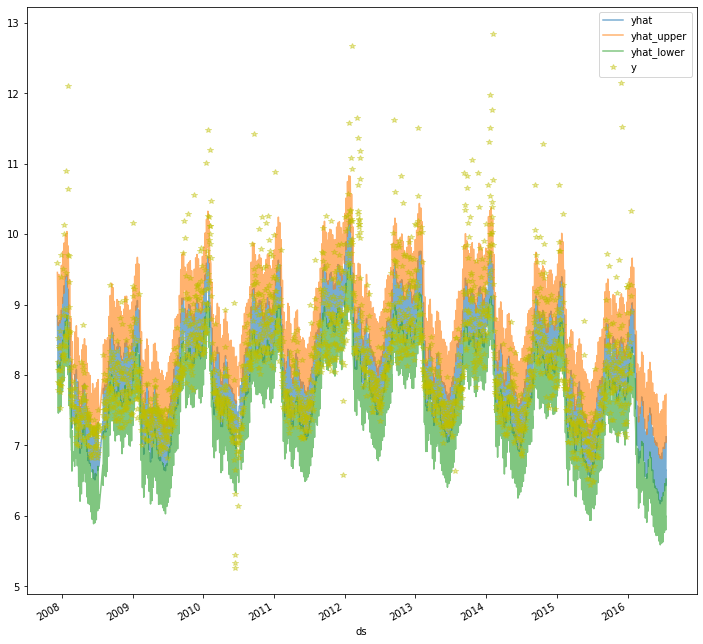

In [9]:
print(pr.json()["header"])
dfr = pd.DataFrame(pr.json()["data"], columns=pr.json()["header"])
dfr["ds"] = pd.to_datetime(dfr['ds'])
ax = dfr.plot("ds",["yhat", "yhat_upper", "yhat_lower"], figsize=[12,12], alpha=0.6)
dft.plot("ds", "y", ax=ax, style="y*", alpha=0.4)